### Notebook for the Facenet MTCNN framework

In [31]:
import os
import glob
import numpy as np
import torch
import pandas as pd
import tqdm
import copy
import time
import cv2 as cv
import matplotlib.pyplot as plt


from facenet_pytorch import MTCNN, RNet
from PIL import Image, ImageDraw
from IPython import display
from skimage import io, transform

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets, models
import torchvision

import torch.nn as nn
import torch.optim as optim

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


from utility import *

### Helper Methods

In [32]:
def get_transformation(input_size) :
    # Data augmentation and normalization for training
    # Just normalization for validation
    data_transforms = {
        'train': transforms.Compose([
            transforms.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6, hue=0.2),
            transforms.Resize(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
        'val': transforms.Compose([
            transforms.Resize(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
    }
    
    return data_transforms

In [33]:
def print_set_exemple(dataloaders_dict) :
    
    dataiter = iter(dataloaders_dict["train"])
    images_display, labels_display = dataiter.next()

    def imshow(img):
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

    imshow(torchvision.utils.make_grid(images_display))
    print(labels_display)

In [34]:
def parameters_to_update(model) : 
    # Gather the parameters to be optimized/updated in this run. If we are
    #  finetuning we will be updating all parameters. However, if we are
    #  doing feature extract method, we will only update the parameters
    #  that we have just initialized, i.e. the parameters with requires_grad
    #  is True.

    params_to_update = model.parameters()
    names = []
    print("Params to learn:")
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
            names.append(name)

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(params_to_update, lr=lambda_, momentum=0.9)
    return optimizer_ft, names

In [35]:
def print_histogram(num_epochs, hist_train, hist_val, folder_store, name) :
    
    plt.plot(range(num_epochs), hist_train, color = "blue", label = "train error")
    plt.plot(range(num_epochs), hist_val, color='orange', label = "val error")
    plt.title("History of the train/val losses")
    plt.legend()
    plt.savefig("mtcnn_models/%s/hist%s.png"%(folder_store, name))
    plt.show()

In [36]:
def train_model(model, dataloaders, criterion, optimizer, network, num_epochs=25):
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    val_err_history = []
    train_err_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                #inputs = inputs.to(device)
                #labels = labels.to(device)
                inputs = inputs.cuda()
                labels = labels.cuda()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if network == "onet" :
                        outputs_box, output_landmark, aux_outputs = model(inputs)
                        
                    else :
                        outputs, aux_outputs = model(inputs)

                    aux_outputs = aux_outputs.reshape(-1, num_classes)
                    loss = criterion(aux_outputs, labels)
                    _, preds = torch.max(aux_outputs, 1)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_err_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_err_history.append(epoch_loss)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_err_history, train_err_history

In [37]:
def pipeline_full_model(model, input_size, network, data_dir, model_name, folder_store, num_epochs = 70, num_classes = 2, batch_size = 32, lambda_ = 0.001) :
    data_transforms = get_transformation(input_size)
    print("Initializing Datasets and Dataloaders...")

    # Create training and validation datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
    # Create training and validation dataloaders
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    print("Printing training images : ")
    print_set_exemple(dataloaders_dict)

    # Gather the parameters to be optimized/updated in this run. If we are
    #  finetuning we will be updating all parameters. However, if we are
    #  doing feature extract method, we will only update the parameters
    #  that we have just initialized, i.e. the parameters with requires_grad
    #  is True.

    optimizer_ft, name_layer = parameters_to_update(model)
    
    # Setup the loss fxn
    criterion = nn.CrossEntropyLoss()
    
    print("Starting the training : ")
    # Train and evaluate
    model_ft, hist_val, hist_train = train_model(model, dataloaders_dict, criterion, optimizer_ft, network, num_epochs=num_epochs)
    
    # Save the model 
    print("Saving the model : ")
    torch.save(mtcnn.state_dict(), "mtcnn_models/%s/%s.pth"%(folder_store, model_name))
    
    
    print_histogram(num_epochs, hist_train, hist_val, folder_store, network)
    
    print("Saving the hyperparameters : ")
    f = open("mtcnn_models/%s/params%s.txt"%(folder_store, network), "w")
    f.write("Dataset : %s"%(data_dir) + '\n')
    f.write("Num epochs : %s"%(num_epochs) + '\n')
    f.write("lambda : %s"%(lambda_) + '\n')
    f.write("Transforms for %s: %s"%(network, data_transforms) + '\n')
    f.write("Layers for %s: %s"%(network, name_layer) + '\n')
    f.close()

In [38]:
from matplotlib import pyplot as plt

def print_exemple(index, images, pred_mtcnn, groundtruth, display = True) :
    copy = images[index].copy()
#     for (column, row, width, height) in pred_vj[index]:
#         cv.rectangle(copy, (column, row), (column + width, row + height), (0, 255, 0), 2 )
    if pred_mtcnn[index] is not None:
        for (column, row, width, height) in pred_mtcnn[index]:
            cv.rectangle(copy, (column, row), (width, height),
            (0, 255, 0), 2 )
        
        
    if groundtruth[index].size > 0 :
        for (x1, y1, x2, y2) in groundtruth[index][:, 1:]:
            cv.rectangle(copy, (x1, y1), (x2, y2), (255, 0, 0), 2)
            
    copy = resize_img(copy, width=680)
    if display :
        cv.imshow("example", copy)
        cv.waitKey(0)  
        cv.destroyAllWindows()  
    return copy

In [39]:
def testing(folder_test, folder_store, network, display = False) :
    # We load the images and groundtruth, the resize them (so the the prediction time is lower)
    
    folder_img="%s/img_train"%(folder_test)
    folder_gt="%s/gt_train"%(folder_test)
    
    images, path_img = load_images_from_folder(folder_img)
    groundtruth, path_gt = load_groundtruth_from_folder(folder_gt, 5)
    resize_img_and_gt(800, images, groundtruth)

    # Convert for MTCNN
    img_mtcnn = [Image.fromarray(cv.cvtColor(frame, cv.COLOR_BGR2RGB)) for frame in images]

    # Detect faces
    pred_mtcnn = []
    for img in tqdm.tqdm(img_mtcnn) :
        detected_faces, _ = mtcnn.detect(img)
        pred_mtcnn.append(detected_faces)
        
    for i in range(len(images)):
        r = print_exemple(i, images, pred_mtcnn, groundtruth, display = False)
        result = cv.imwrite("mtcnn_models/%s/sample_test/%s/%s.jpg"%(folder_store, network, f"{i:04}"), r)
        
    tp_tot, fp_tot, fn_tot = compute_metrics(groundtruth, pred_mtcnn)
    precision, recall, f_score = prec_rec_f(tp_tot, fp_tot, fn_tot)
    print(precision, recall, f_score)


    f = open("mtcnn_models/%s/params%s.txt"%(folder_store, network), "a")
    f.write("Results : Precision : %s, Recall : %s, F_score : %s"%(precision, recall, f_score) + '\n')

    f.close()
    
    return pred_mtcnn, groundtruth

In [10]:
def output_single_model(model, test_dir, data_transforms, network, batch_size = 32) :
    
    print("Initializing test set...")
    #test_dir = "./dataset/faces/good/testing_v2/train"

    # Create training and validation datasets
    test_datasets = datasets.ImageFolder(test_dir, data_transforms['val'])
    # Create training and validation dataloaders
    dataloaders_dict = torch.utils.data.DataLoader(test_datasets, batch_size=batch_size, num_workers=4)

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    i = 0
    for inputs, labels in dataloaders_dict :
        inputs = inputs.cuda()
        labels = labels.cuda()
        # zero the parameter gradients
        model.eval()

        with torch.set_grad_enabled(False):

            print("batch ", i)
            i += 1 
            if network == "onet":
                outputs_box, output_landmark, aux_outputs = model(inputs)
            else :
                outputs, aux_outputs = model(inputs)
            aux_outputs = aux_outputs.reshape(-1, num_classes)
            loss = criterion(aux_outputs, labels)
            _, preds = torch.max(aux_outputs, 1)
            print("loss : ", loss)
            print("pred : ", aux_outputs)
            print("labels : ", labels)


In [51]:
folder_test = "../dataset/faces/testing"

In [52]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

In [53]:
data_transforms = get_transformation(12)

In [54]:
output_single_model(mtcnn.pnet, folder_test, data_transforms, "pnet")

Initializing test set...
batch  0
loss :  tensor(0.7857, device='cuda:0')
pred :  tensor([[1.2035e-01, 8.7965e-01],
        [5.5095e-04, 9.9945e-01],
        [2.3964e-01, 7.6036e-01],
        [2.4132e-01, 7.5868e-01],
        [5.7578e-01, 4.2422e-01],
        [9.5206e-05, 9.9990e-01],
        [9.3732e-01, 6.2681e-02],
        [4.8299e-01, 5.1701e-01],
        [9.2678e-01, 7.3219e-02],
        [6.6282e-02, 9.3372e-01],
        [1.5673e-01, 8.4327e-01],
        [5.7873e-01, 4.2127e-01],
        [6.8625e-01, 3.1375e-01],
        [7.7474e-01, 2.2526e-01],
        [3.5027e-02, 9.6497e-01],
        [3.3990e-01, 6.6010e-01],
        [7.9551e-01, 2.0449e-01],
        [1.0292e-02, 9.8971e-01],
        [2.2046e-04, 9.9978e-01],
        [2.8345e-01, 7.1655e-01],
        [4.3394e-01, 5.6606e-01],
        [1.2035e-01, 8.7965e-01],
        [5.5095e-04, 9.9945e-01],
        [2.3964e-01, 7.6036e-01],
        [2.4132e-01, 7.5868e-01],
        [5.7578e-01, 4.2422e-01],
        [9.5206e-05, 9.9990e-01],


In [55]:
data_transforms = get_transformation(24)

In [56]:
output_single_model(mtcnn.rnet, folder_test, data_transforms, "rnet")

Initializing test set...
batch  0
loss :  tensor(0.7851, device='cuda:0')
pred :  tensor([[8.9671e-01, 1.0329e-01],
        [6.1512e-02, 9.3849e-01],
        [7.7014e-01, 2.2986e-01],
        [9.5300e-01, 4.6999e-02],
        [9.7301e-01, 2.6987e-02],
        [9.8904e-04, 9.9901e-01],
        [3.1955e-01, 6.8045e-01],
        [9.8381e-01, 1.6190e-02],
        [8.9302e-01, 1.0698e-01],
        [2.2492e-01, 7.7508e-01],
        [9.4093e-01, 5.9069e-02],
        [9.8520e-01, 1.4800e-02],
        [6.0704e-01, 3.9296e-01],
        [4.1141e-01, 5.8859e-01],
        [1.3558e-01, 8.6442e-01],
        [7.3733e-01, 2.6267e-01],
        [9.9189e-01, 8.1149e-03],
        [3.6719e-03, 9.9633e-01],
        [6.0869e-03, 9.9391e-01],
        [5.6550e-01, 4.3450e-01],
        [2.9452e-02, 9.7055e-01],
        [8.9671e-01, 1.0329e-01],
        [6.1512e-02, 9.3849e-01],
        [7.7014e-01, 2.2986e-01],
        [9.5300e-01, 4.6999e-02],
        [9.7301e-01, 2.6987e-02],
        [9.8904e-04, 9.9901e-01],


In [57]:
data_transforms = get_transformation(48)

In [58]:
output_single_model(mtcnn.onet, folder_test, data_transforms, "onet")

Initializing test set...
batch  0
loss :  tensor(0.6966, device='cuda:0')
pred :  tensor([[0.7936, 0.2064],
        [0.0807, 0.9193],
        [0.9790, 0.0210],
        [0.9884, 0.0116],
        [0.9862, 0.0138],
        [0.3133, 0.6867],
        [0.9509, 0.0491],
        [0.9969, 0.0031],
        [0.9058, 0.0942],
        [0.0176, 0.9824],
        [0.8401, 0.1599],
        [0.9950, 0.0050],
        [0.9822, 0.0178],
        [0.9324, 0.0676],
        [0.1426, 0.8574],
        [0.9560, 0.0440],
        [0.9904, 0.0096],
        [0.8525, 0.1475],
        [0.0064, 0.9936],
        [0.9942, 0.0058],
        [0.9185, 0.0815],
        [0.7936, 0.2064],
        [0.0807, 0.9193],
        [0.9790, 0.0210],
        [0.9884, 0.0116],
        [0.9862, 0.0138],
        [0.3133, 0.6867],
        [0.9509, 0.0491],
        [0.9969, 0.0031],
        [0.9058, 0.0942],
        [0.0176, 0.9824],
        [0.8401, 0.1599]], device='cuda:0')
labels :  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Presets

In [18]:
## To load a model :
mtcnn.load_state_dict(torch.load("mtcnn_models/full_training_v1/full_training_v1.pth", map_location=device))

<All keys matched successfully>

In [20]:
# Top level data directory. Here we assume the format of the directory conforms to the ImageFolder structure
data_dir = "./dataset/faces/good/v2"

# Model name to save the parameters
model_name = "full_training_v1"
folder_store = "full_training_v1"

# Number of classes in the dataset (Here only faces/not faces)
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for
num_epochs = 10

# Learning Rate 
lambda_ = 0.0001

In [48]:
# Check cuda + load model 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))
mtcnn = MTCNN(keep_all=True, device=device, thresholds = [0.5, 0.7, 0.7])

Running on device: cuda:0


### Train Pnet

In [14]:
# Here we are interested by the Pnet of the MTCNN 
model = mtcnn.pnet
network = "pnet"
input_size = 12

# Chose the layers to freeze
# model.conv1.weight.requires_grad = False
# model.conv1.bias.requires_grad = False
# model.prelu1.weight.requires_grad = False


#model.conv2.weight.requires_grad = False
#model.conv2.bias.requires_grad = False
#model.prelu2.weight.requires_grad = False


# model.conv3.weight.requires_grad = False
# model.conv3.bias.requires_grad = False
# model.prelu3.weight.requires_grad = False


model.conv4_2.weight.requires_grad = False
model.conv4_2.bias.requires_grad = False

# Set the model to cuda
model = model.cuda()

Initializing Datasets and Dataloaders...
Printing training images : 


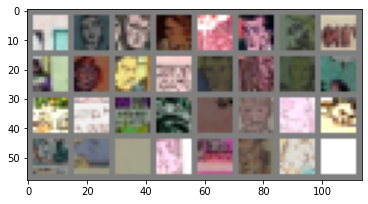

tensor([0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 1, 0, 1, 1, 0])
Params to learn:
	 conv1.weight
	 conv1.bias
	 prelu1.weight
	 conv2.weight
	 conv2.bias
	 prelu2.weight
	 conv3.weight
	 conv3.bias
	 prelu3.weight
	 conv4_1.weight
	 conv4_1.bias
Starting the training : 
Epoch 0/9
----------
train Loss: 0.5362 Acc: 0.7597
val Loss: 0.4683 Acc: 0.8410
Epoch 1/9
----------
train Loss: 0.4969 Acc: 0.8099
val Loss: 0.4562 Acc: 0.8538
Epoch 2/9
----------
train Loss: 0.4764 Acc: 0.8310
val Loss: 0.4420 Acc: 0.8697
Epoch 3/9
----------
train Loss: 0.4714 Acc: 0.8379
val Loss: 0.4389 Acc: 0.8721
Epoch 4/9
----------
train Loss: 0.4628 Acc: 0.8469
val Loss: 0.4323 Acc: 0.8800
Epoch 5/9
----------
train Loss: 0.4565 Acc: 0.8542
val Loss: 0.4271 Acc: 0.8873
Epoch 6/9
----------
train Loss: 0.4532 Acc: 0.8565
val Loss: 0.4249 Acc: 0.8910
Epoch 7/9
----------
train Loss: 0.4503 Acc: 0.8607
val Loss: 0.4196 Acc: 0.8940
Epoch 8/9
----------
train Loss: 

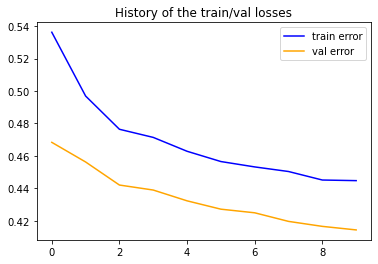

Saving the hyperparameters : 


In [15]:
pipeline_full_model(model, input_size, network, data_dir, model_name, folder_store, num_epochs = num_epochs, lambda_ = lambda_)

In [16]:
# Top level data directory. Here we assume the format of the directory conforms to the ImageFolder structure
data_dir = "./dataset/faces/good/v2"

# Model name to save the parameters
model_name = "full_training_v1"

folder_store = "full_training_v1"

# Number of classes in the dataset (Here only faces/not faces)
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for
num_epochs = 30

# Learning Rate 
lambda_ = 0.001

In [17]:
# Check cuda + load model 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))
mtcnn = MTCNN(keep_all=True, device=device, thresholds = [0.5, 0.7, 0.7])

Running on device: cuda:0


In [18]:
# Here we are interested by the Pnet of the MTCNN 
model = mtcnn.pnet
network = "pnet"
input_size = 12

# Chose the layers to freeze
# model.conv1.weight.requires_grad = False
# model.conv1.bias.requires_grad = False
# model.prelu1.weight.requires_grad = False


#model.conv2.weight.requires_grad = False
#model.conv2.bias.requires_grad = False
#model.prelu2.weight.requires_grad = False


# model.conv3.weight.requires_grad = False
# model.conv3.bias.requires_grad = False
# model.prelu3.weight.requires_grad = False


model.conv4_2.weight.requires_grad = False
model.conv4_2.bias.requires_grad = False

# Set the model to cuda
model = model.cuda()

Initializing Datasets and Dataloaders...
Printing training images : 


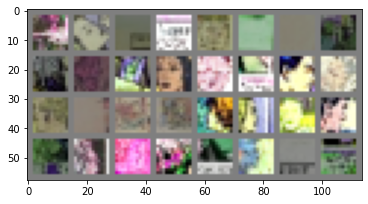

tensor([0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
        0, 1, 1, 0, 0, 1, 0, 0])
Params to learn:
	 conv1.weight
	 conv1.bias
	 prelu1.weight
	 conv2.weight
	 conv2.bias
	 prelu2.weight
	 conv3.weight
	 conv3.bias
	 prelu3.weight
	 conv4_1.weight
	 conv4_1.bias
Starting the training : 
Epoch 0/29
----------
train Loss: 0.4751 Acc: 0.8301
val Loss: 0.4227 Acc: 0.8867
Epoch 1/29
----------
train Loss: 0.4371 Acc: 0.8724
val Loss: 0.4070 Acc: 0.9080
Epoch 2/29
----------
train Loss: 0.4300 Acc: 0.8805
val Loss: 0.3978 Acc: 0.9147
Epoch 3/29
----------
train Loss: 0.4256 Acc: 0.8829
val Loss: 0.3969 Acc: 0.9123
Epoch 4/29
----------
train Loss: 0.4198 Acc: 0.8883
val Loss: 0.3968 Acc: 0.9153
Epoch 5/29
----------
train Loss: 0.4185 Acc: 0.8901
val Loss: 0.3914 Acc: 0.9190
Epoch 6/29
----------
train Loss: 0.4173 Acc: 0.8928
val Loss: 0.3867 Acc: 0.9233
Epoch 7/29
----------
train Loss: 0.4179 Acc: 0.8917
val Loss: 0.3847 Acc: 0.9300
Epoch 8/29
----------
tra

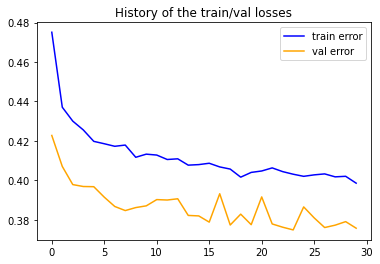

Saving the hyperparameters : 


In [19]:
pipeline_full_model(model, input_size, network, data_dir, model_name, folder_store, num_epochs = num_epochs, lambda_ = lambda_)

### Test Pnet

In [20]:
folder_test = "dataset/train_test/good"

pred_mtcnn, groundtruth = testing(folder_test, folder_store, network)

100%|██████████| 18/18 [00:14<00:00,  1.28it/s]


0.816 0.6538461538461539 0.7259786476868327


### Train Rnet

In [21]:
# Here we are interested by the Pnet of the MTCNN 
model = mtcnn.rnet

# Chose the layers to freeze
model.conv1.weight.requires_grad = False
model.conv1.bias.requires_grad = False
model.prelu1.weight.requires_grad = False


model.conv2.weight.requires_grad = False
model.conv2.bias.requires_grad = False
model.prelu2.weight.requires_grad = False

# model.conv3.weight.requires_grad = False
# model.conv3.bias.requires_grad = False
# model.prelu3.weight.requires_grad = False

# model.dense4.weight.requires_grad = False
# model.dense4.bias.requires_grad = False
# model.prelu4.weight.requires_grad = False

model.dense5_2.weight.requires_grad = False
model.dense5_2.bias.requires_grad = False

# Set the model to cuda
model = model.cuda()

network = "rnet"
input_size = 24
num_epochs = 10


Initializing Datasets and Dataloaders...
Printing training images : 


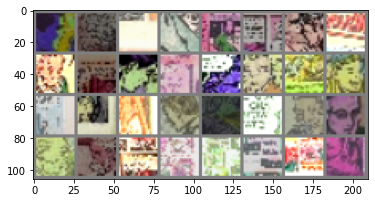

tensor([1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0])
Params to learn:
	 conv3.weight
	 conv3.bias
	 prelu3.weight
	 dense4.weight
	 dense4.bias
	 prelu4.weight
	 dense5_1.weight
	 dense5_1.bias
Starting the training : 
Epoch 0/9
----------
train Loss: 0.4390 Acc: 0.8706
val Loss: 0.4028 Acc: 0.9050
Epoch 1/9
----------
train Loss: 0.4087 Acc: 0.9011
val Loss: 0.3860 Acc: 0.9263
Epoch 2/9
----------
train Loss: 0.4012 Acc: 0.9079
val Loss: 0.3902 Acc: 0.9178
Epoch 3/9
----------
train Loss: 0.3980 Acc: 0.9132
val Loss: 0.3786 Acc: 0.9318
Epoch 4/9
----------
train Loss: 0.3948 Acc: 0.9173
val Loss: 0.3760 Acc: 0.9361
Epoch 5/9
----------
train Loss: 0.3925 Acc: 0.9176
val Loss: 0.3848 Acc: 0.9245
Epoch 6/9
----------
train Loss: 0.3922 Acc: 0.9168
val Loss: 0.3757 Acc: 0.9361
Epoch 7/9
----------
train Loss: 0.3902 Acc: 0.9203
val Loss: 0.3692 Acc: 0.9391
Epoch 8/9
----------
train Loss: 0.3846 Acc: 0.9267
val Loss: 0.3742 Acc:

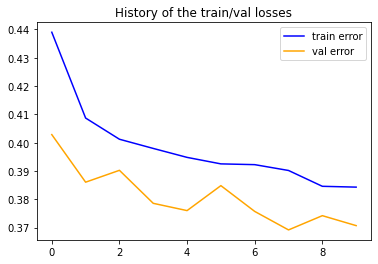

Saving the hyperparameters : 


In [22]:
pipeline_full_model(model, input_size, network, data_dir, model_name, folder_store, num_epochs = num_epochs, lambda_ = lambda_)

### Test Rnet

In [23]:
folder_test = "dataset/train_test/good"

pred_mtcnn, groundtruth = testing(folder_test, folder_store, network)

100%|██████████| 18/18 [00:17<00:00,  1.01it/s]


0.6497175141242938 0.7371794871794872 0.6906906906906908


### Train Onet

In [24]:
# Here we are interested by the Pnet of the MTCNN 
model = mtcnn.onet

# Chose the layers to freeze
model.conv1.weight.requires_grad = False
model.conv1.bias.requires_grad = False
model.prelu1.weight.requires_grad = False


model.conv2.weight.requires_grad = False
model.conv2.bias.requires_grad = False
model.prelu2.weight.requires_grad = False

# model.conv3.weight.requires_grad = False
# model.conv3.bias.requires_grad = False
# model.prelu3.weight.requires_grad = False

# model.conv4.weight.requires_grad = False
# model.conv4.bias.requires_grad = False
# model.prelu4.weight.requires_grad = False

# model.dense5.weight.requires_grad = False
# model.dense5.bias.requires_grad = False
# model.prelu5.weight.requires_grad = False

model.dense6_2.weight.requires_grad = False
model.dense6_2.bias.requires_grad = False

model.dense6_3.weight.requires_grad = False
model.dense6_3.bias.requires_grad = False

# Set the model to cuda
model = model.cuda()


network = "onet"
input_size = 48
num_epochs = 10
lambda_ = 0.0001

Initializing Datasets and Dataloaders...
Printing training images : 


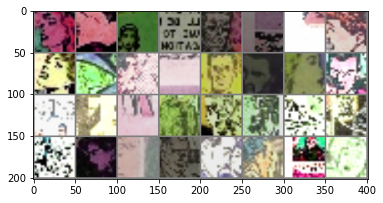

tensor([1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 1, 0, 1, 1, 1, 0, 1])
Params to learn:
	 conv3.weight
	 conv3.bias
	 prelu3.weight
	 conv4.weight
	 conv4.bias
	 prelu4.weight
	 dense5.weight
	 dense5.bias
	 prelu5.weight
	 dense6_1.weight
	 dense6_1.bias
Starting the training : 
Epoch 0/9
----------
train Loss: 0.4754 Acc: 0.8338
val Loss: 0.4074 Acc: 0.9141
Epoch 1/9
----------
train Loss: 0.4233 Acc: 0.8908
val Loss: 0.3930 Acc: 0.9245
Epoch 2/9
----------
train Loss: 0.4112 Acc: 0.9006
val Loss: 0.3857 Acc: 0.9300
Epoch 3/9
----------
train Loss: 0.4033 Acc: 0.9100
val Loss: 0.3846 Acc: 0.9287
Epoch 4/9
----------
train Loss: 0.4016 Acc: 0.9100
val Loss: 0.3788 Acc: 0.9348
Epoch 5/9
----------
train Loss: 0.3968 Acc: 0.9148
val Loss: 0.3790 Acc: 0.9354
Epoch 6/9
----------
train Loss: 0.3934 Acc: 0.9179
val Loss: 0.3802 Acc: 0.9354
Epoch 7/9
----------
train Loss: 0.3935 Acc: 0.9171
val Loss: 0.3750 Acc: 0.9373
Epoch 8/9
----------
train Lo

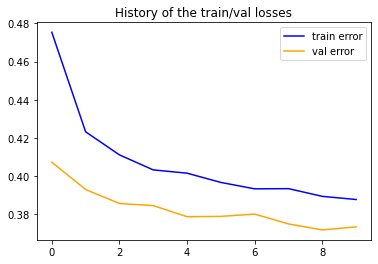

Saving the hyperparameters : 


In [25]:
pipeline_full_model(model, input_size, network, data_dir, model_name, folder_store, num_epochs = num_epochs, lambda_ = 0.0001)

### Test Onet

In [28]:
folder_test = "dataset/train_test/good"

pred_mtcnn, groundtruth = testing(folder_test, folder_store, network)

100%|██████████| 125/125 [01:45<00:00,  1.19it/s]


0.07184633789711552 0.8661858974358975 0.12446456933779147


In [48]:
def bb_intersection_over_union(boxA, boxB):
    
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou


In [63]:
def get_neg_sample(img, gt, pred, nb_total, crop_size):
    
    faces = [x[1:] for x in gt if (x[0] == 7 or x[0] == 11)]
    
    max_size = int(min(img.shape[0], img.shape[1]) * 0.20)
    min_size = int(min(img.shape[0], img.shape[1]) * 0.05)
    
    valid_crop = []
    
    for r_crop in pred:
        valid = True
        for face in faces:
            if(bb_intersection_over_union(r_crop, face)) > 0.3 : 
                valid = False
                break
        if(valid):
            valid_crop.append(r_crop)
            
        #if(len(valid_crop) >= nb_total):
         #   break
            
    crops = []
    for (column, row, c_end, r_end) in valid_crop :
        crops.append(img[max(0, int(row)):int(r_end), int(column):int(c_end)])
        
    if (len(crops) != 0) :
        crops = [cv.resize(crop, (crop_size, crop_size), interpolation=cv.INTER_LINEAR) for crop in crops]
    return crops

In [69]:
c = get_neg_sample(img, groundtruth[1], pred_mtcnn[0], 10, 50)

error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-r2ue8w6k\opencv\modules\imgproc\src\resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [70]:
result = cv.imwrite("test.jpg", c[0])

In [45]:
img = cv.imread("dataset/train_test/good/img_train/0000.jpg")

In [46]:
img

array([[[215, 231, 243],
        [215, 231, 243],
        [216, 232, 244],
        ...,
        [134, 146, 146],
        [137, 147, 147],
        [137, 147, 147]],

       [[223, 239, 251],
        [223, 239, 251],
        [223, 239, 251],
        ...,
        [176, 188, 188],
        [179, 189, 189],
        [179, 189, 189]],

       [[231, 245, 255],
        [231, 245, 255],
        [231, 245, 255],
        ...,
        [192, 204, 206],
        [195, 204, 207],
        [196, 205, 208]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [27]:
# Check cuda + load model 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))
mtcnn = MTCNN(keep_all=True, device=device, thresholds = [0.5, 0.7, 0.7])

Running on device: cuda:0


In [59]:
# Here we are interested by the Pnet of the MTCNN 
model = mtcnn.pnet

# Chose the layers to freeze
model.conv1.weight.requires_grad = False
model.conv1.bias.requires_grad = False
model.prelu1.weight.requires_grad = False


model.conv2.weight.requires_grad = False
model.conv2.bias.requires_grad = False
model.prelu2.weight.requires_grad = False


# model.conv3.weight.requires_grad = False
# model.conv3.bias.requires_grad = False
# model.prelu3.weight.requires_grad = False


model.conv4_2.weight.requires_grad = False
model.conv4_2.bias.requires_grad = False

# Set the model to cuda
model = model.cuda()

In [60]:
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.


params_to_update = model.parameters()
names = []
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
            names.append(name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)
            names.append(name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=lambda_, momentum=0.9)

Params to learn:
	 conv3.weight
	 conv3.bias
	 prelu3.weight
	 conv4_1.weight
	 conv4_1.bias


### Training Pnet

In [62]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val, hist_train = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/69
----------
train Loss: 0.5091 Acc: 0.7931
val Loss: 0.4422 Acc: 0.8743
Epoch 1/69
----------
train Loss: 0.4808 Acc: 0.8250
val Loss: 0.4379 Acc: 0.8778
Epoch 2/69
----------
train Loss: 0.4712 Acc: 0.8355
val Loss: 0.4363 Acc: 0.8749
Epoch 3/69
----------
train Loss: 0.4647 Acc: 0.8436
val Loss: 0.4346 Acc: 0.8760
Epoch 4/69
----------
train Loss: 0.4639 Acc: 0.8429
val Loss: 0.4330 Acc: 0.8743
Epoch 5/69
----------
train Loss: 0.4604 Acc: 0.8474
val Loss: 0.4302 Acc: 0.8826
Epoch 6/69
----------
train Loss: 0.4574 Acc: 0.8499
val Loss: 0.4299 Acc: 0.8832
Epoch 7/69
----------
train Loss: 0.4555 Acc: 0.8520
val Loss: 0.4277 Acc: 0.8850
Epoch 8/69
----------
train Loss: 0.4532 Acc: 0.8559
val Loss: 0.4260 Acc: 0.8868
Epoch 9/69
----------
train Loss: 0.4549 Acc: 0.8513
val Loss: 0.4275 Acc: 0.8832
Epoch 10/69
----------
train Loss: 0.4545 Acc: 0.8540
val Loss: 0.4289 Acc: 0.8850
Epoch 11/69
----------
train Loss: 0.4534 Acc: 0.8538
val Loss: 0.4267 Acc: 0.8832
Epoch 12/69
--

In [63]:
# Save the model 

torch.save(mtcnn.state_dict(), "mtcnn_models/%s/%s.pth"%(folder_store, model_name))

## SAVE THE HYPERPARAMS

### Print the val and training loss to detect overfitting

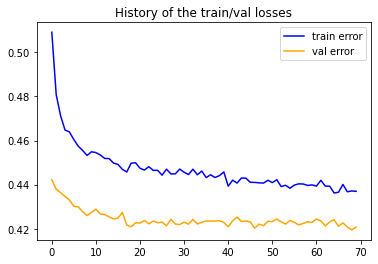

In [64]:
plt.plot(range(num_epochs), hist_train, color = "blue", label = "train error")
plt.plot(range(num_epochs), hist_val, color='orange', label = "val error")
plt.title("History of the train/val losses")
plt.legend()
plt.savefig("mtcnn_models/%s/hist.png"%(folder_store))
plt.show()

In [65]:
f = open("mtcnn_models/%s/params.txt"%(folder_store), "w")
f.write("Dataset : %s"%(data_dir) + '\n')
f.write("Num epochs : %s"%(num_epochs) + '\n')
f.write("lambda : %s"%(lambda_) + '\n')
f.write("Transforms : %s"%(data_transforms) + '\n')
f.write("Layers : %s"%(names) + '\n')

f.close()

### Testing and Evaluation

In [66]:
from matplotlib import pyplot as plt

def print_exemple(index, display = True) :
    copy = images[index].copy()
#     for (column, row, width, height) in pred_vj[index]:
#         cv.rectangle(copy, (column, row), (column + width, row + height), (0, 255, 0), 2 )
    if pred_mtcnn[index] is not None:
        for (column, row, width, height) in pred_mtcnn[index]:
            cv.rectangle(copy, (column, row), (width, height),
            (0, 255, 0), 2 )
        
        
    if groundtruth[index].size > 0 :
        for (x1, y1, x2, y2) in groundtruth[index][:, 1:]:
            cv.rectangle(copy, (x1, y1), (x2, y2), (255, 0, 0), 2)
            
    copy = resize_img(copy, width=680)
    if display :
        cv.imshow("example", copy)
        cv.waitKey(0)  
        cv.destroyAllWindows()  
    return copy

In [67]:
def box_pred(p, b = False) :
    if b :
        return (p[0], p[1], p[0] + p[2], p[1] + p[3])
    else :
        return (p[0], p[1], p[2], p[3])

In [68]:
def metric_img(index, groundtruth, pred, b_pred = False) :
    
    tp_img = 0
    fp_img = 0
    already_found = []
    if pred[index] is None :
        return 0, 0, len(groundtruth[index])
    for j in range(len(pred[index])):
        max_ = 0
        max_index = -1
        for k in range(len(groundtruth[index])) :
            if k not in already_found :
                iou = bb_intersection_over_union(box_pred(pred[index][j], b_pred), groundtruth[index][k][1:])
                if iou > max_ : 
                    max_ = iou
                    max_index = k
        if max_ > 0.4: 
            tp_img += 1
            already_found.append(max_index)
        else : fp_img += 1
    fn_img = len(groundtruth[index]) - tp_img
                
    return tp_img, fp_img, fn_img

def compute_metrics(groundtruth, pred, b_pred = False):
    
    fp_tot = 0
    tp_tot = 0
    fn_tot = 0

    for i in range(len(pred)):
        tp, fp, fn = metric_img(i, groundtruth, pred, b_pred)
        fn_tot += fn
        tp_tot += tp
        fp_tot += fp
                
    return tp_tot, fp_tot, fn_tot


def get_nb_files_per_comics(folder) :
    lengths = []
    for subdir, dirs, files in os.walk(folder):
        if "checkpoints" not in files and "checkpoints" not in dirs and "checkpoints" not in subdir :
            lengths.append(len(files))
    return lengths[1:]


def prec_rec_f(tp, fp, fn) :
    if (tp + fp + fn) == 0:
        precision = 1
        recall = 1
        f_score = 1
    else :
        precision = (tp/max(1, (tp + fp)))
        recall = (tp/max(1, (tp + fn)))
        f_score = (precision * recall * 2)/max(1, (precision + recall))
    return precision, recall, f_score


def compute_metric_per_comic(groundtruth, pred, folder):
    l = get_nb_files_per_comics(folder)
    results = []
    for i in range(len(l)):
        tp_tot, fp_tot, fn_tot = compute_metrics(groundtruth[sum(l[:i]):sum(l[:i+1])], pred[sum(l[:i]):sum(l[:i+1])], b_pred)
        precision, recall, f_score = prec_rec_f(tp_tot, fp_tot, fn_tot)
        results.append((tp_tot, fp_tot, fn_tot, round(precision, 3), round(recall,3), round(f_score,3)))
    
    return results

    
def get_dict_comics() :
    folder = "dcm_dataset.git/images/images"
    length = get_nb_files_per_comics(folder)
    sum_ = 0
    r = {}
    for i, l in enumerate(length):
        r[i] = ((sum_, l+sum_))
        sum_ += l
    return r

In [69]:
def print_exemple_comic(id_, dict_comics, nb = 100):
    for i in range(dict_comics[id_][0], min(dict_comics[id_][0] + nb, dict_comics[id_][1])):
        print_exemple(i)

In [70]:
def bb_intersection_over_union(boxA, boxB):
    
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [71]:
def load_groundtruth_from_folder(folder, shape = 5):
    '''
    Load all groundtruths from a given folder and return them in an array.
    Return only the faces gt

    :param str folder: The path to the needed folder
    :param int shape:  Usefull when groundtruth has already been manipulated, default = 5 
    (class, top_left_x, top_left_y, bottom_right_x, bottom_right_y)
    :return: Array of groundtruths
    :return: Array of paths
    '''
    
    groundtruth = []
    path = []
    for subdir, dirs, files in os.walk(folder):
        for filename in files:
            filepath = subdir + os.sep + filename
                      
            f = open(filepath, "r")
            if "checkpoints" not in filepath:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    groundtruth.append(np.loadtxt(f, dtype = int))
                    path.append(filepath)
    
    groundtruth = np.array(groundtruth)
    groundtruth = [x.reshape(-1, shape) for x in groundtruth]
    return  [gt[((gt[:, 0] == 7) | (gt[:, 0] == 11))] for gt in groundtruth], path

In [72]:
# We load the images and groundtruth, the resize them (so the the prediction time is lower)
folder_img="dataset/train_test/average/img_test"
folder_gt="dataset/train_test/average/gt_test"

images, path_img = load_images_from_folder(folder_img)
groundtruth, path_gt = load_groundtruth_from_folder(folder_gt, 5)
resize_img_and_gt(1200, images, groundtruth)

In [73]:
# Convert for MTCNN
img_mtcnn = [Image.fromarray(cv.cvtColor(frame, cv.COLOR_BGR2RGB)) for frame in images]

In [74]:
# Detect faces
pred_mtcnn = []

for img in tqdm.tqdm(img_mtcnn) :
    detected_faces, _ = mtcnn.detect(img)
    pred_mtcnn.append(detected_faces)

100%|██████████| 33/33 [01:25<00:00,  2.59s/it]


In [75]:
for i in range(len(images)):
    r = print_exemple(i, display = False)
    result = cv.imwrite("mtcnn_models/%s/sample_test/%s.jpg"%(folder_store, f"{i:04}"), r)

In [76]:
tp_tot, fp_tot, fn_tot = compute_metrics(groundtruth, pred_mtcnn)
precision, recall, f_score = prec_rec_f(tp_tot, fp_tot, fn_tot)
print(precision, recall, f_score)


f = open("mtcnn_models/%s/params.txt"%(folder_store), "a")
f.write("Results : Precision : %s, Recall : %s, F_score : %s"%(precision, recall, f_score) + '\n')

f.close()

0.42857142857142855 0.3944223107569721 0.33807626636311894


#### Check Pnet 

In [45]:
print("Initializing test set...")

test_dir = "./dataset/faces/average/testing/train"

# Create training and validation datasets
test_datasets = datasets.ImageFolder(test_dir, data_transforms['val'])
# Create training and validation dataloaders
dataloaders_dict = torch.utils.data.DataLoader(test_datasets, batch_size=batch_size, num_workers=4)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing test set...


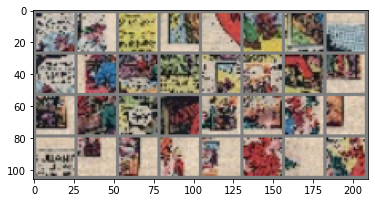

In [46]:
dataiter = iter(dataloaders_dict)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

In [47]:
labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [48]:
i = 0
for inputs, labels in dataloaders_dict :
    inputs = inputs.cuda()
    labels = labels.cuda()
    # zero the parameter gradients
    model.eval()

    with torch.set_grad_enabled(False):
        
        print("batch ", i)
        i += 1 
        outputs, aux_outputs = model(inputs)
        aux_outputs = aux_outputs.reshape(-1, num_classes)
        loss = criterion(aux_outputs, labels)
        _, preds = torch.max(aux_outputs, 1)
        print("loss : ", loss)
        print("pred : ", aux_outputs)
        print("labels : ", labels)


batch  0
loss :  tensor(0.5193, device='cuda:0')
pred :  tensor([[6.9067e-01, 3.0933e-01],
        [5.3322e-01, 4.6678e-01],
        [8.1617e-01, 1.8383e-01],
        [8.7675e-01, 1.2325e-01],
        [9.3918e-01, 6.0825e-02],
        [9.7558e-01, 2.4418e-02],
        [8.0283e-01, 1.9717e-01],
        [9.7756e-01, 2.2443e-02],
        [2.9435e-01, 7.0565e-01],
        [8.5645e-01, 1.4355e-01],
        [8.6293e-01, 1.3707e-01],
        [9.9821e-01, 1.7949e-03],
        [9.8997e-01, 1.0033e-02],
        [8.1791e-01, 1.8209e-01],
        [9.6748e-01, 3.2516e-02],
        [9.9502e-01, 4.9835e-03],
        [9.6650e-01, 3.3504e-02],
        [4.5930e-01, 5.4070e-01],
        [3.4910e-01, 6.5090e-01],
        [3.4838e-02, 9.6516e-01],
        [9.8962e-01, 1.0375e-02],
        [9.1475e-01, 8.5248e-02],
        [2.9982e-02, 9.7002e-01],
        [9.0826e-01, 9.1743e-02],
        [9.4594e-01, 5.4061e-02],
        [9.9944e-01, 5.6392e-04],
        [8.7221e-01, 1.2779e-01],
        [4.2960e-01, 5.70

### Check Rnet

In [49]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms_rnet = {
    'val': transforms.Compose([
        transforms.Resize(24),
        #transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [50]:
print("Initializing test set...")

test_dir = "./dataset/faces/good/testing_v2/train"

# Create training and validation datasets
test_datasets = datasets.ImageFolder(test_dir, data_transforms_rnet['val'])
# Create training and validation dataloaders
dataloaders_dict = torch.utils.data.DataLoader(test_datasets, batch_size=batch_size, num_workers=4)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing test set...


In [51]:
test = mtcnn.rnet
test = test.cuda()

In [52]:
i = 0
for inputs, labels in dataloaders_dict :
    inputs = inputs.cuda()
    labels = labels.cuda()
    # zero the parameter gradients
    test.eval()

    with torch.set_grad_enabled(False):
        
        print("batch ", i)
        i += 1 
        outputs, aux_outputs = test(inputs)
        aux_outputs = aux_outputs.reshape(-1, num_classes)
        loss = criterion(aux_outputs, labels)
        _, preds = torch.max(aux_outputs, 1)
        print("loss : ", loss)
        print("pred : ", aux_outputs)
        print("labels : ", labels)


batch  0
loss :  tensor(0.4688, device='cuda:0')
pred :  tensor([[0.6858, 0.3142],
        [0.6539, 0.3461],
        [0.9347, 0.0653],
        [0.9443, 0.0557],
        [0.6509, 0.3491],
        [0.9544, 0.0456],
        [0.9866, 0.0134],
        [0.9802, 0.0198],
        [0.1133, 0.8867],
        [0.8971, 0.1029],
        [0.9490, 0.0510],
        [0.9659, 0.0341],
        [0.8813, 0.1187],
        [0.9590, 0.0410],
        [0.9886, 0.0115],
        [0.4592, 0.5408],
        [0.9953, 0.0047],
        [0.8881, 0.1119],
        [0.9033, 0.0967],
        [0.8457, 0.1543],
        [0.4192, 0.5808],
        [0.8804, 0.1196],
        [0.6660, 0.3340],
        [0.9739, 0.0261],
        [0.9775, 0.0225],
        [0.9334, 0.0666],
        [0.9805, 0.0195],
        [0.7440, 0.2560],
        [0.4218, 0.5782],
        [0.7978, 0.2022],
        [0.7774, 0.2226],
        [0.1707, 0.8293]], device='cuda:0')
labels :  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
   

### Train Rnet

In [33]:
# Number of classes in the dataset (Here only faces/not faces)
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for
num_epochs = 15

# Learning Rate 
lambda_ = 0.001

# Input size of the images (Here 12*12 pixels)
input_size = 24

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [34]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6, hue=0.2),
        transforms.Resize(input_size),
        #transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        #transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [35]:
# Here we are interested by the Pnet of the MTCNN 
model = mtcnn.rnet

# Chose the layers to freeze
model.conv1.weight.requires_grad = False
model.conv1.bias.requires_grad = False
model.prelu1.weight.requires_grad = False


model.conv2.weight.requires_grad = False
model.conv2.bias.requires_grad = False
model.prelu2.weight.requires_grad = False

model.conv3.weight.requires_grad = False
model.conv3.bias.requires_grad = False
model.prelu3.weight.requires_grad = False

# model.dense4.weight.requires_grad = False
# model.dense4.bias.requires_grad = False
# model.prelu4.weight.requires_grad = False

model.dense5_2.weight.requires_grad = False
model.dense5_2.bias.requires_grad = False

# Set the model to cuda
model = model.cuda()

In [36]:
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.


params_to_update = model.parameters()
names = []
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
            names.append(name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)
            names.append(name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=lambda_, momentum=0.9)

Params to learn:
	 dense4.weight
	 dense4.bias
	 prelu4.weight
	 dense5_1.weight
	 dense5_1.bias


In [37]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val, hist_train = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 0.4717 Acc: 0.8423
val Loss: 0.4417 Acc: 0.8749
Epoch 1/14
----------


KeyboardInterrupt: 

#### Results all faces

In [ ]:
# We load the images and groundtruth, the resize them (so the the prediction time is lower)
folder_img="dataset/train_test/average/img_train"
folder_gt="dataset/train_test/average/gt_train"

images, path_img = load_images_from_folder(folder_img)
groundtruth, path_gt = load_groundtruth_from_folder(folder_gt, 5)
resize_img_and_gt(1200, images, groundtruth)

In [ ]:
# Convert for MTCNN
img_mtcnn = [Image.fromarray(cv.cvtColor(frame, cv.COLOR_BGR2RGB)) for frame in images]

In [ ]:
# Detect faces
pred_mtcnn = []

for img in tqdm.tqdm(img_mtcnn) :
    detected_faces, _ = mtcnn.detect(img)
    pred_mtcnn.append(detected_faces)

In [ ]:
tp_tot, fp_tot, fn_tot = compute_metrics(groundtruth, pred_mtcnn)
precision, recall, f_score = prec_rec_f(tp_tot, fp_tot, fn_tot)
print(precision, recall, f_score)


f = open("mtcnn_models/%s/params.txt"%(folder_store), "a")
f.write("(train) Results : Precision : %s, Recall : %s, F_score : %s"%(precision, recall, f_score) + '\n')

f.close()

In [ ]:
tp_tot, fp_tot, fn_tot = compute_metrics(groundtruth, pred_mtcnn)
precision, recall, f_score = prec_rec_f(tp_tot, fp_tot, fn_tot)
print(precision, recall, f_score)


f = open("mtcnn_models/%s/params.txt"%(folder_store), "a")
f.write("(train + r_net) Results : Precision : %s, Recall : %s, F_score : %s"%(precision, recall, f_score) + '\n')

f.close()

In [13]:
folder = "dataset/images/images"

dict_comics = get_dict_comics(folder)

results = compute_metric_per_comic(groundtruth, pred_mtcnn, folder)
print("Id, tp, fp, fn , prec, recall, f_score")
for i, r in enumerate(results) :
    print(i, r)

Id, tp, fp, fn , prec, recall, f_score


In [ ]:
tp_tot, fp_tot, fn_tot = compute_metrics(groundtruth, pred_mtcnn)
precision, recall, f_score = prec_rec_f(tp_tot, fp_tot, fn_tot)
print(precision, recall, f_score)


f = open("mtcnn_models/%s/params.txt"%(folder_store), "a")
f.write("Results : Precision : %s, Recall : %s, F_score : %s"%(precision, recall, f_score) + '\n')

f.close()

In [ ]:
df = pd.DataFrame(results, columns=['tp', 'fp', 'fn', 'prec', 'recall', 'f_score'])
df.to_csv("mtcnn_models/%s/results.csv"%(folder_store))

In [ ]:
# import random

# sample_test = []
# for i in range(50) :
#     sample_test.append(random.randint(0, 772))

sample_test = [477, 749, 457,87,464, 5, 346, 499, 528, 32, 103, 163, 442, 78, 354, 438, 48, 496, 368, 206,
               284, 3, 219, 353, 409, 755, 72, 244, 132, 669, 24, 668, 67, 624, 156, 55, 266, 7, 152, 154, 526, 224, 313, 518, 90, 745, 227, 102, 247, 721]

for i in sample_test:
    r = print_exemple(i, display = False)
    result = cv.imwrite("mtcnn_models/%s/sample_test/%s.jpg"%(folder_store, f"{i:04}"), r)

Retrain the model with different freeze for layers 
Histogram (overtraining) 
decrease learning rate and increase epochs
data augmentation (brightness, contrast, multiple time same faces, colors (to check)) 



Test training last layer
optimizer
loss
try result only pnet


Process : 
- Train on 48 Famous americans 
- Test on one similar comic (Love experience) (Visual + metrics) 
- Test on one really different comic  (Visual + metrics) 
- Invert (train on comic style, test on realistic) 

Goal :
- Pre trained model 
- Baseline (no data augmentation, 30 epochs, only one layer)
- Baseline (no data augmentation, 50 epochs or largest learning rate, only one layer)
- Best Baseline + change of layers (all combinations)
- Best Baseline + UNFREEZE of layers (all combinations)
- Best of two + data augmentation (color, brigthness, Hue / Mutliple faces)  

In [443]:
def get_models(folder):
    paths = []
    for subdir, dirs, files in os.walk(folder):
        for filename in files:
            filepath = subdir + os.sep + filename
            paths.append(filepath)
    return paths

In [445]:
models = get_models("models/mtcnn")

In [ ]:
folder_img="new_set/img_test"
folder_gt="new_set/gt_test"

images, path_img = load_images_from_folder(folder_img)
groundtruth, path_gt = load_groundtruth_from_folder(folder_gt, 5)
resize_img_and_gt(800, images, groundtruth)

In [ ]:
img_mtcnn = [Image.fromarray(cv.cvtColor(frame, cv.COLOR_BGR2RGB)) for frame in images[:-1]]

In [461]:
# Check cuda + load model 

for j, model in enumerate(models) :
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('Running on device: {}'.format(device))
    mtcnn = MTCNN(keep_all=True, device=device, thresholds = [0.5, 0.7, 0.7])
    
    mtcnn.load_state_dict(torch.load(model, map_location=device))
    
    mtcnn.eval()

    # Detect faces
    pred_mtcnn = []

    for i, img in enumerate(tqdm.tqdm(img_mtcnn)) :
        detected_faces, _ = mtcnn.detect(img)
        pred_mtcnn.append(detected_faces)
        r = print_exemple(i, display = False)
        result = cv.imwrite("test/%s/%s.jpg"%(j, f"{i:04}"), r)

    tp_tot, fp_tot, fn_tot = compute_metrics(groundtruth, pred_mtcnn)
    precision, recall, f_score = prec_rec_f(tp_tot, fp_tot, fn_tot)
    print(model, precision, recall, f_score)

  0%|          | 0/84 [00:00<?, ?it/s]

Running on device: cuda:0


  0%|          | 0/84 [00:00<?, ?it/s]

models/mtcnn\Baseline.pth 0.6290672451193059 0.4588607594936709 0.5306495882891125
Running on device: cuda:0


  0%|          | 0/84 [00:00<?, ?it/s]

models/mtcnn\baseline_other_style.pth 0.6490825688073395 0.4477848101265823 0.5299625468164794
Running on device: cuda:0


  0%|          | 0/84 [00:00<?, ?it/s]

models/mtcnn\Baseline_v2.pth 0.6187363834422658 0.44936708860759494 0.5206232813932171
Running on device: cuda:0


  0%|          | 0/84 [00:00<?, ?it/s]

models/mtcnn\data_aug_s1_v1.pth 0.5945378151260504 0.4477848101265823 0.5108303249097472
Running on device: cuda:0


  0%|          | 0/84 [00:00<?, ?it/s]

models/mtcnn\data_aug_s1_v2.pth 0.6261061946902655 0.4477848101265823 0.522140221402214
Running on device: cuda:0


  0%|          | 0/84 [00:00<?, ?it/s]

models/mtcnn\data_aug_s3_v1.pth 0.6265060240963856 0.4936708860759494 0.5522123893805311
Running on device: cuda:0


  0%|          | 0/84 [00:00<?, ?it/s]

models/mtcnn\layer_s1_v1.pth 0.6610978520286396 0.43829113924050633 0.527117031398668
Running on device: cuda:0


  0%|          | 0/84 [00:00<?, ?it/s]

models/mtcnn\layer_s1_v2.pth 0.6936708860759494 0.43354430379746833 0.5335929892891919
Running on device: cuda:0


  0%|          | 0/84 [00:00<?, ?it/s]

models/mtcnn\layer_s2_v1.pth 0.7115384615384616 0.4098101265822785 0.5200803212851406
Running on device: cuda:0


  0%|          | 0/84 [00:00<?, ?it/s]

models/mtcnn\layer_s2_v2.pth 0.7211796246648794 0.42563291139240506 0.5353233830845772
Running on device: cuda:0


  0%|          | 0/84 [00:00<?, ?it/s]

models/mtcnn\model_abbott.pth 0.5885947046843177 0.4572784810126582 0.514692787177204
Running on device: cuda:0


  0%|          | 0/84 [00:00<?, ?it/s]

models/mtcnn\model_all_faces.pth 0.6758104738154613 0.4287974683544304 0.5246853823814134
Running on device: cuda:0


  0%|          | 0/84 [00:00<?, ?it/s]

models/mtcnn\model_famous_data_aug_no_test.pth 0.5833333333333334 0.4430379746835443 0.5035971223021583
Running on device: cuda:0


  0%|          | 0/84 [00:00<?, ?it/s]

models/mtcnn\model_famous_data_aug_with_test.pth 0.561122244488978 0.4430379746835443 0.49513704686118476
Running on device: cuda:0


 88%|████████▊ | 74/84 [02:12<00:17,  1.79s/it]


IndexError: The shape of the mask [13082] at index 0 does not match the shape of the indexed tensor [13083, 4] at index 0

In [466]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))
mtcnn = MTCNN(keep_all=True, device=device, thresholds = [0.5, 0.7, 0.7])

mtcnn.load_state_dict(torch.load("models/mtcnn\\test_final_v2.pth", map_location=device))

mtcnn.eval()

# Detect faces
pred_mtcnn = []

for i, img in enumerate(tqdm.tqdm(img_mtcnn[:-1])) :
    detected_faces, _ = mtcnn.detect(img)
    pred_mtcnn.append(detected_faces)
    r = print_exemple(i, display = False)
    result = cv.imwrite("test/%s/%s.jpg"%(14, f"{i:04}"), r)

tp_tot, fp_tot, fn_tot = compute_metrics(groundtruth, pred_mtcnn)
precision, recall, f_score = prec_rec_f(tp_tot, fp_tot, fn_tot)
print(model, precision, recall, f_score)

  0%|          | 0/83 [00:00<?, ?it/s]

Running on device: cuda:0


100%|██████████| 83/83 [02:57<00:00,  2.14s/it]

models/mtcnn\test_final_v1.pth 0.6453744493392071 0.4680511182108626 0.5425925925925925


In [478]:
dirname = "mtcnn_models".split(os.path.sep)[-1]

In [482]:
os.listdir('mtcnn_models')

['baseline',
 'baseline_other_style',
 'baseline_v2',
 'data_aug_s1_v1',
 'data_aug_s1_v2',
 'data_aug_s3_v1',
 'layer_s1_v1',
 'layer_s1_v2',
 'layer_s2_v1',
 'layer_s2_v2',
 'pretrained',
 'test_final_v1',
 'test_final_v2']

In [500]:
df_tot = pd.DataFrame()

for dirs in os.listdir('mtcnn_models') :
    if os.path.isfile("mtcnn_models/%s/results.csv"%(dirs)):
        df_tot[dirs] = pd.read_csv("mtcnn_models/%s/results.csv"%(dirs))["f_score"]

In [467]:
df = pd.read_csv("mtcnn_models/pretrained/results.csv")

In [496]:
def highlight_max(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

In [501]:
df_tot.style.highlight_max(color = 'lightgreen', axis = 1)

,baseline,baseline_other_style,baseline_v2,data_aug_s1_v1,data_aug_s1_v2,data_aug_s3_v1,layer_s1_v1,layer_s1_v2,layer_s2_v1,layer_s2_v2,pretrained
0,0.710000,0.712000,0.706000,0.698000,0.703000,0.719000,0.726000,0.694000,0.715000,0.732000,0.707000
1,0.488000,0.479000,0.475000,0.488000,0.483000,0.479000,0.488000,0.489000,0.426000,0.479000,0.426000
2,0.616000,0.597000,0.616000,0.623000,0.623000,0.623000,0.633000,0.636000,0.635000,0.635000,0.661000
3,0.413000,0.442000,0.430000,0.442000,0.478000,0.435000,0.404000,0.438000,0.458000,0.490000,0.408000
4,0.231000,0.252000,0.215000,0.248000,0.261000,0.281000,0.218000,0.245000,0.261000,0.276000,0.245000
5,0.705000,0.733000,0.716000,0.704000,0.713000,0.713000,0.710000,0.688000,0.723000,0.734000,0.702000
6,0.119000,0.165000,0.141000,0.120000,0.145000,0.168000,0.225000,0.094000,0.174000,0.201000,0.134000
7,0.703000,0.632000,0.632000,0.684000,0.649000,0.762000,0.387000,0.514000,0.595000,0.588000,0.571000
8,0.429000,0.457000,0.460000,0.405000,0.484000,0.514000,0.505000,0.514000,0.505000,0.520000,0.463000
9,0.147000,0.164000,0.148000,0.182000,0.197000,0.150000,0.118000,0.177000,0.174000,0.128000,0.167000
